In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE


# **Data Analysis**

In [2]:
# Loading the data
data = pd.read_csv('diabetes.csv')

# Data Analysis
print(data.describe())
print(data.info())



       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  

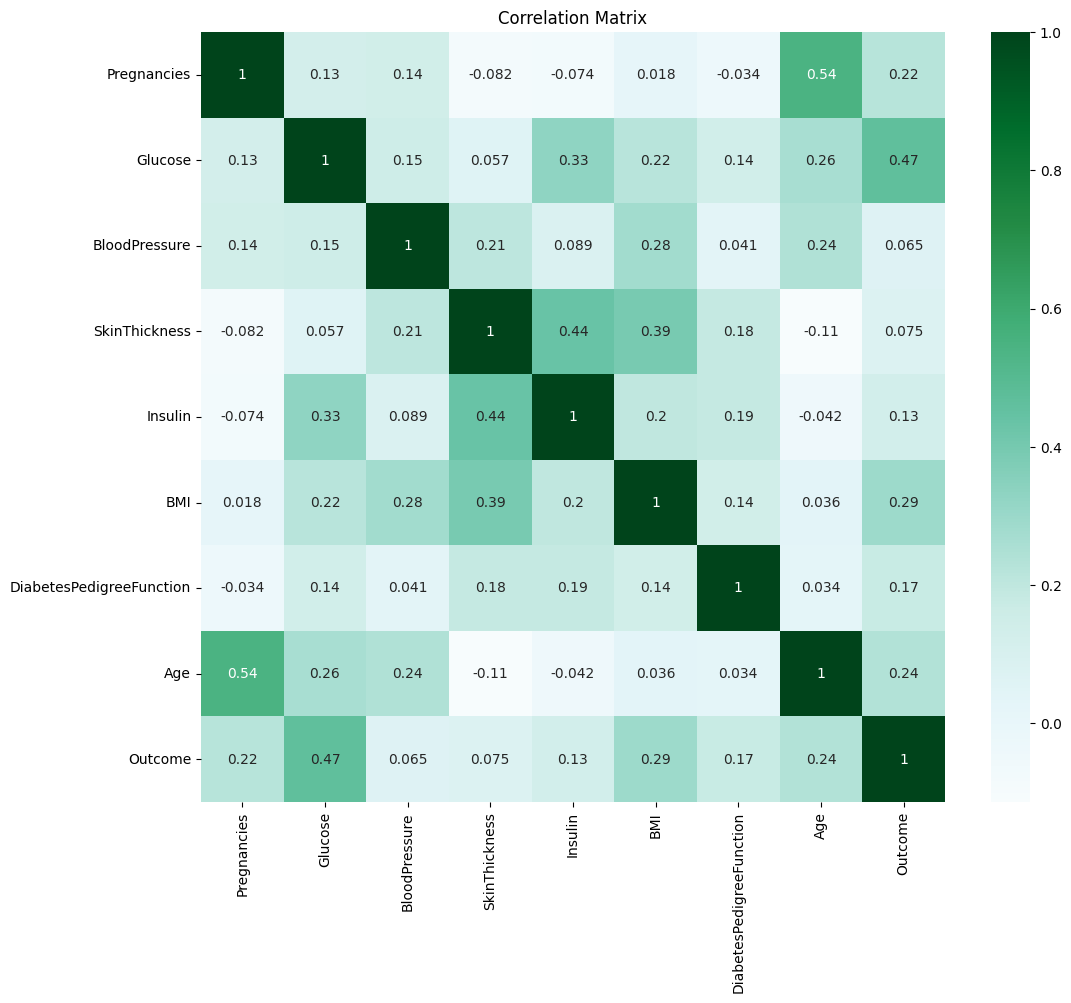

In [3]:
# Correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(data.corr(), annot=True, cmap='BuGn')
plt.title('Correlation Matrix')
plt.show()


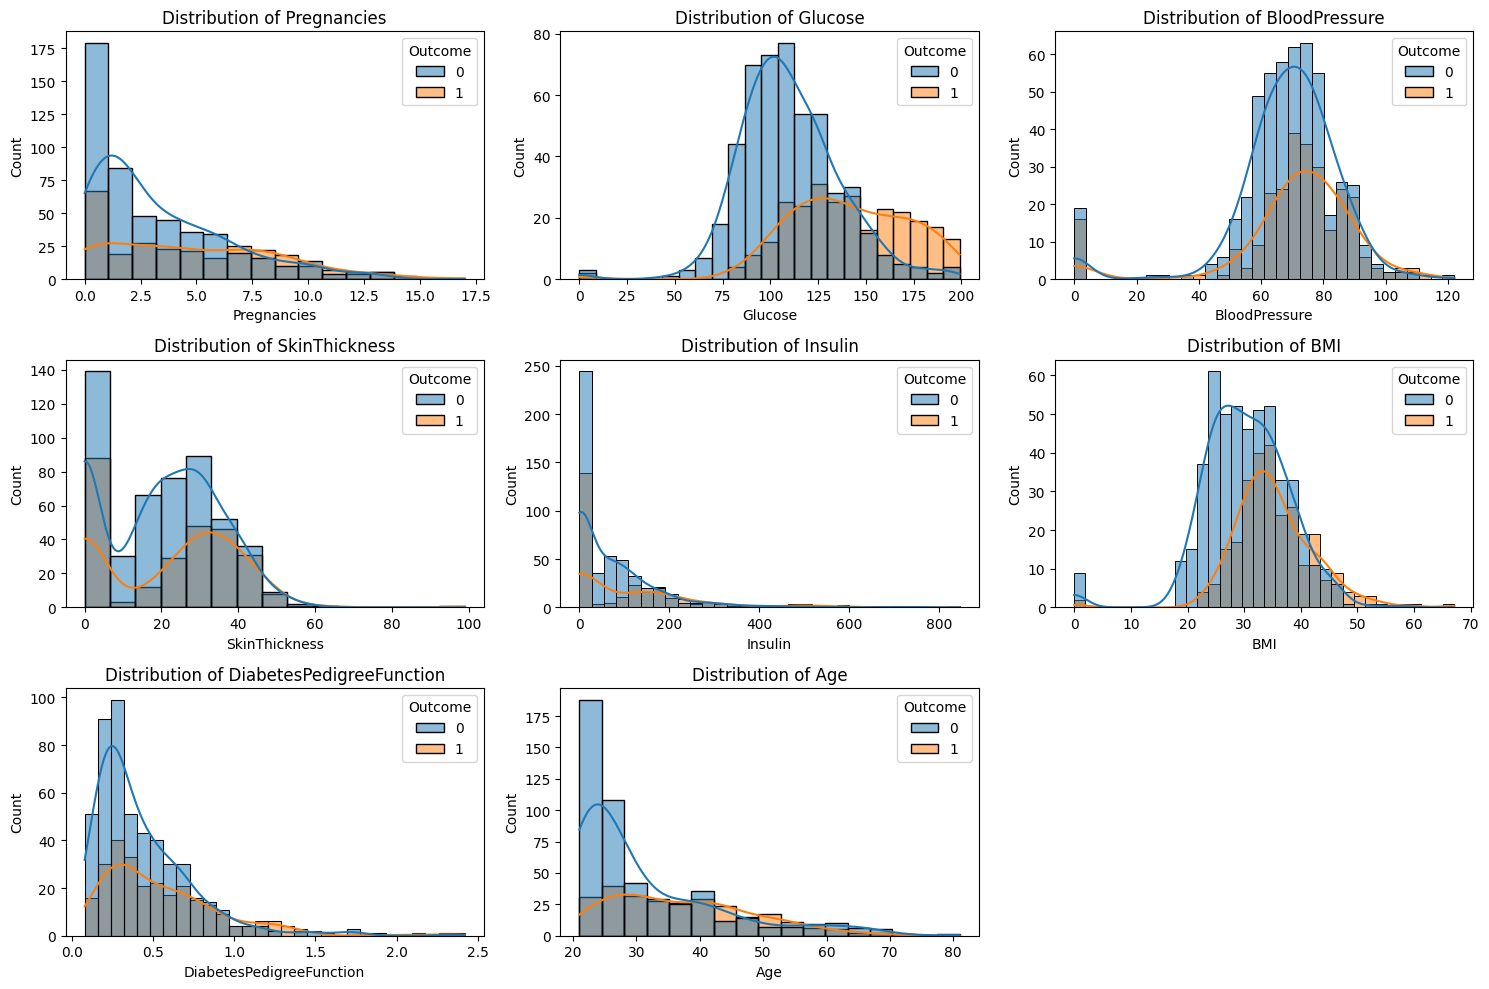

In [4]:
# Distribution of features
plt.figure(figsize=(15, 10))
for i, col in enumerate(data.columns[:-1]):
    plt.subplot(3, 3, i+1)
    sns.histplot(data=data, x=col, hue='Outcome', kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()


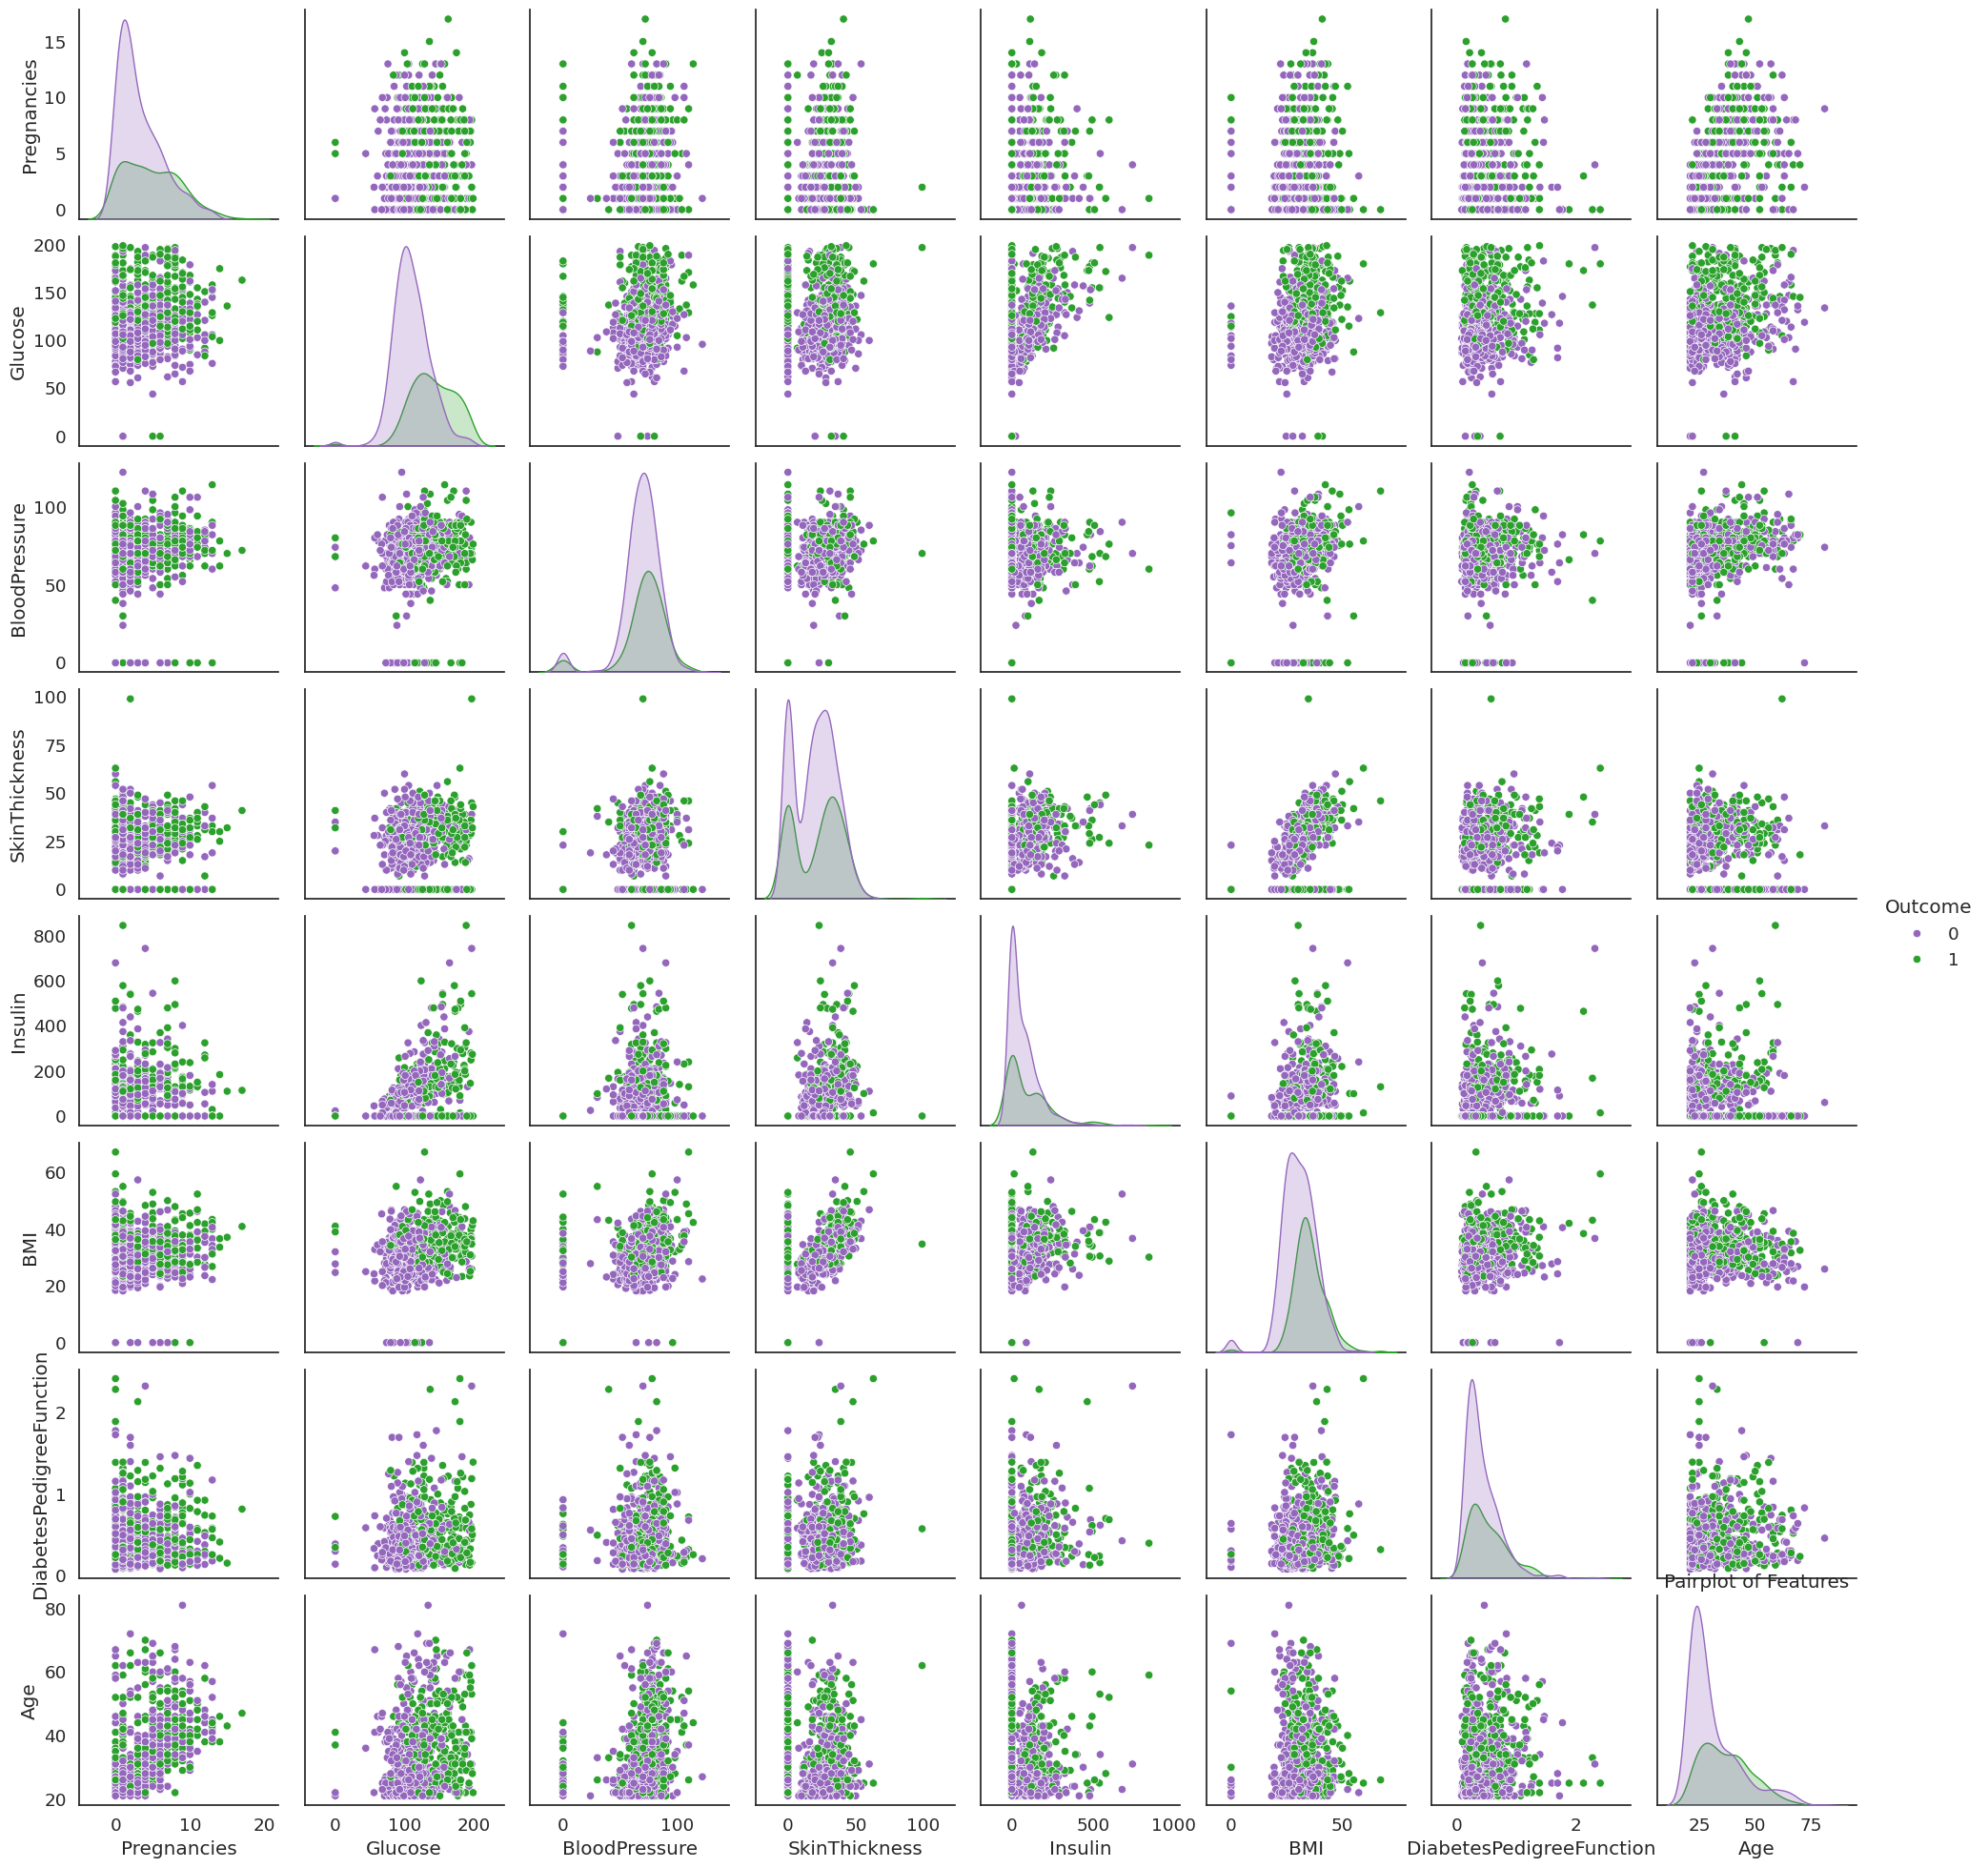

In [90]:
# Pairplot
custom_palette = ['#1f77b4',  '#2ca02c']
sns.pairplot(data, hue='Outcome', palette=custom_palette)
plt.title('Pairplot of Features')
plt.show()


# **Data Pre-processing**

In [5]:
# Separting input and output
X = data.drop('Outcome', axis=1)
y = data['Outcome']

# Handle missing values (replace 0 with mean for certain features)
zero_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for feature in zero_features:
    X[feature] = X[feature].replace(0, X[feature].mean())

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Oversample the minority class using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

In [6]:
# Feature Selection
selector = SelectKBest(f_classif, k=5)
X_train_selected = selector.fit_transform(X_train_scaled, y_train_resampled)
X_test_selected = selector.transform(X_test_scaled)

selected_features = X.columns[selector.get_support()].tolist()
print("Selected features:", selected_features)

Selected features: ['Pregnancies', 'Glucose', 'SkinThickness', 'BMI', 'Age']


# **Training Various Perceptron Models**

In [8]:
# SLP
slp = Perceptron(random_state=42)
slp.fit(X_train_selected, y_train)

# MLP
mlp = MLPClassifier(hidden_layer_sizes=(10, 5), random_state=42)
mlp.fit(X_train_selected, y_train)

# VP(using PassiveAggressiveClassifier)
vp = PassiveAggressiveClassifier(random_state=42)
vp.fit(X_train_selected, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


PassiveAggressiveClassifier(random_state=42)

# **Evaluating Model Performance**

In [9]:
models = [
    ("Single-layer Perceptron", slp),
    ("Multi-layer Perceptron", mlp),
    ("Voted Perceptron", vp)
]

#accuracy and classification report
for name, model in models:
    y_pred = model.predict(X_test_selected)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\n{name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))


Single-layer Perceptron Results:
Accuracy: 0.6753
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.95      0.79        99
           1       0.67      0.18      0.29        55

    accuracy                           0.68       154
   macro avg       0.67      0.57      0.54       154
weighted avg       0.67      0.68      0.61       154


Multi-layer Perceptron Results:
Accuracy: 0.7597
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.82      0.81        99
           1       0.67      0.65      0.66        55

    accuracy                           0.76       154
   macro avg       0.74      0.74      0.74       154
weighted avg       0.76      0.76      0.76       154


Voted Perceptron Results:
Accuracy: 0.7143
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.87      0.80        99
           1       0.65

In [16]:
#functions for plotting confusion matrix, roc curve, and learning curve.
def plot_confusion_matrix(y_true, y_pred, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='BuPu', ax=ax, cbar=False, annot_kws={"size": 28})
    ax.set_title(title, fontsize=22)
    ax.set_ylabel('True label', fontsize=18)
    ax.set_xlabel('Predicted label', fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=16)

def plot_roc_curve(y_true, y_pred_proba, ax, title):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color='#1f77b4', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    ax.plot([0, 1], [0, 1], color='#ff7f0e', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=18)
    ax.set_ylabel('True Positive Rate', fontsize=18)
    ax.set_title(title, fontsize=22)
    ax.legend(loc="lower right", fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=16)

def plot_learning_curve(estimator, X, y, ax, title):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    ax.set_title(title, fontsize=22)
    ax.set_xlabel("Training examples", fontsize=18)
    ax.set_ylabel("Score", fontsize=18)
    ax.grid()
    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="b", label="Training score")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    ax.legend(loc="best", fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=16)

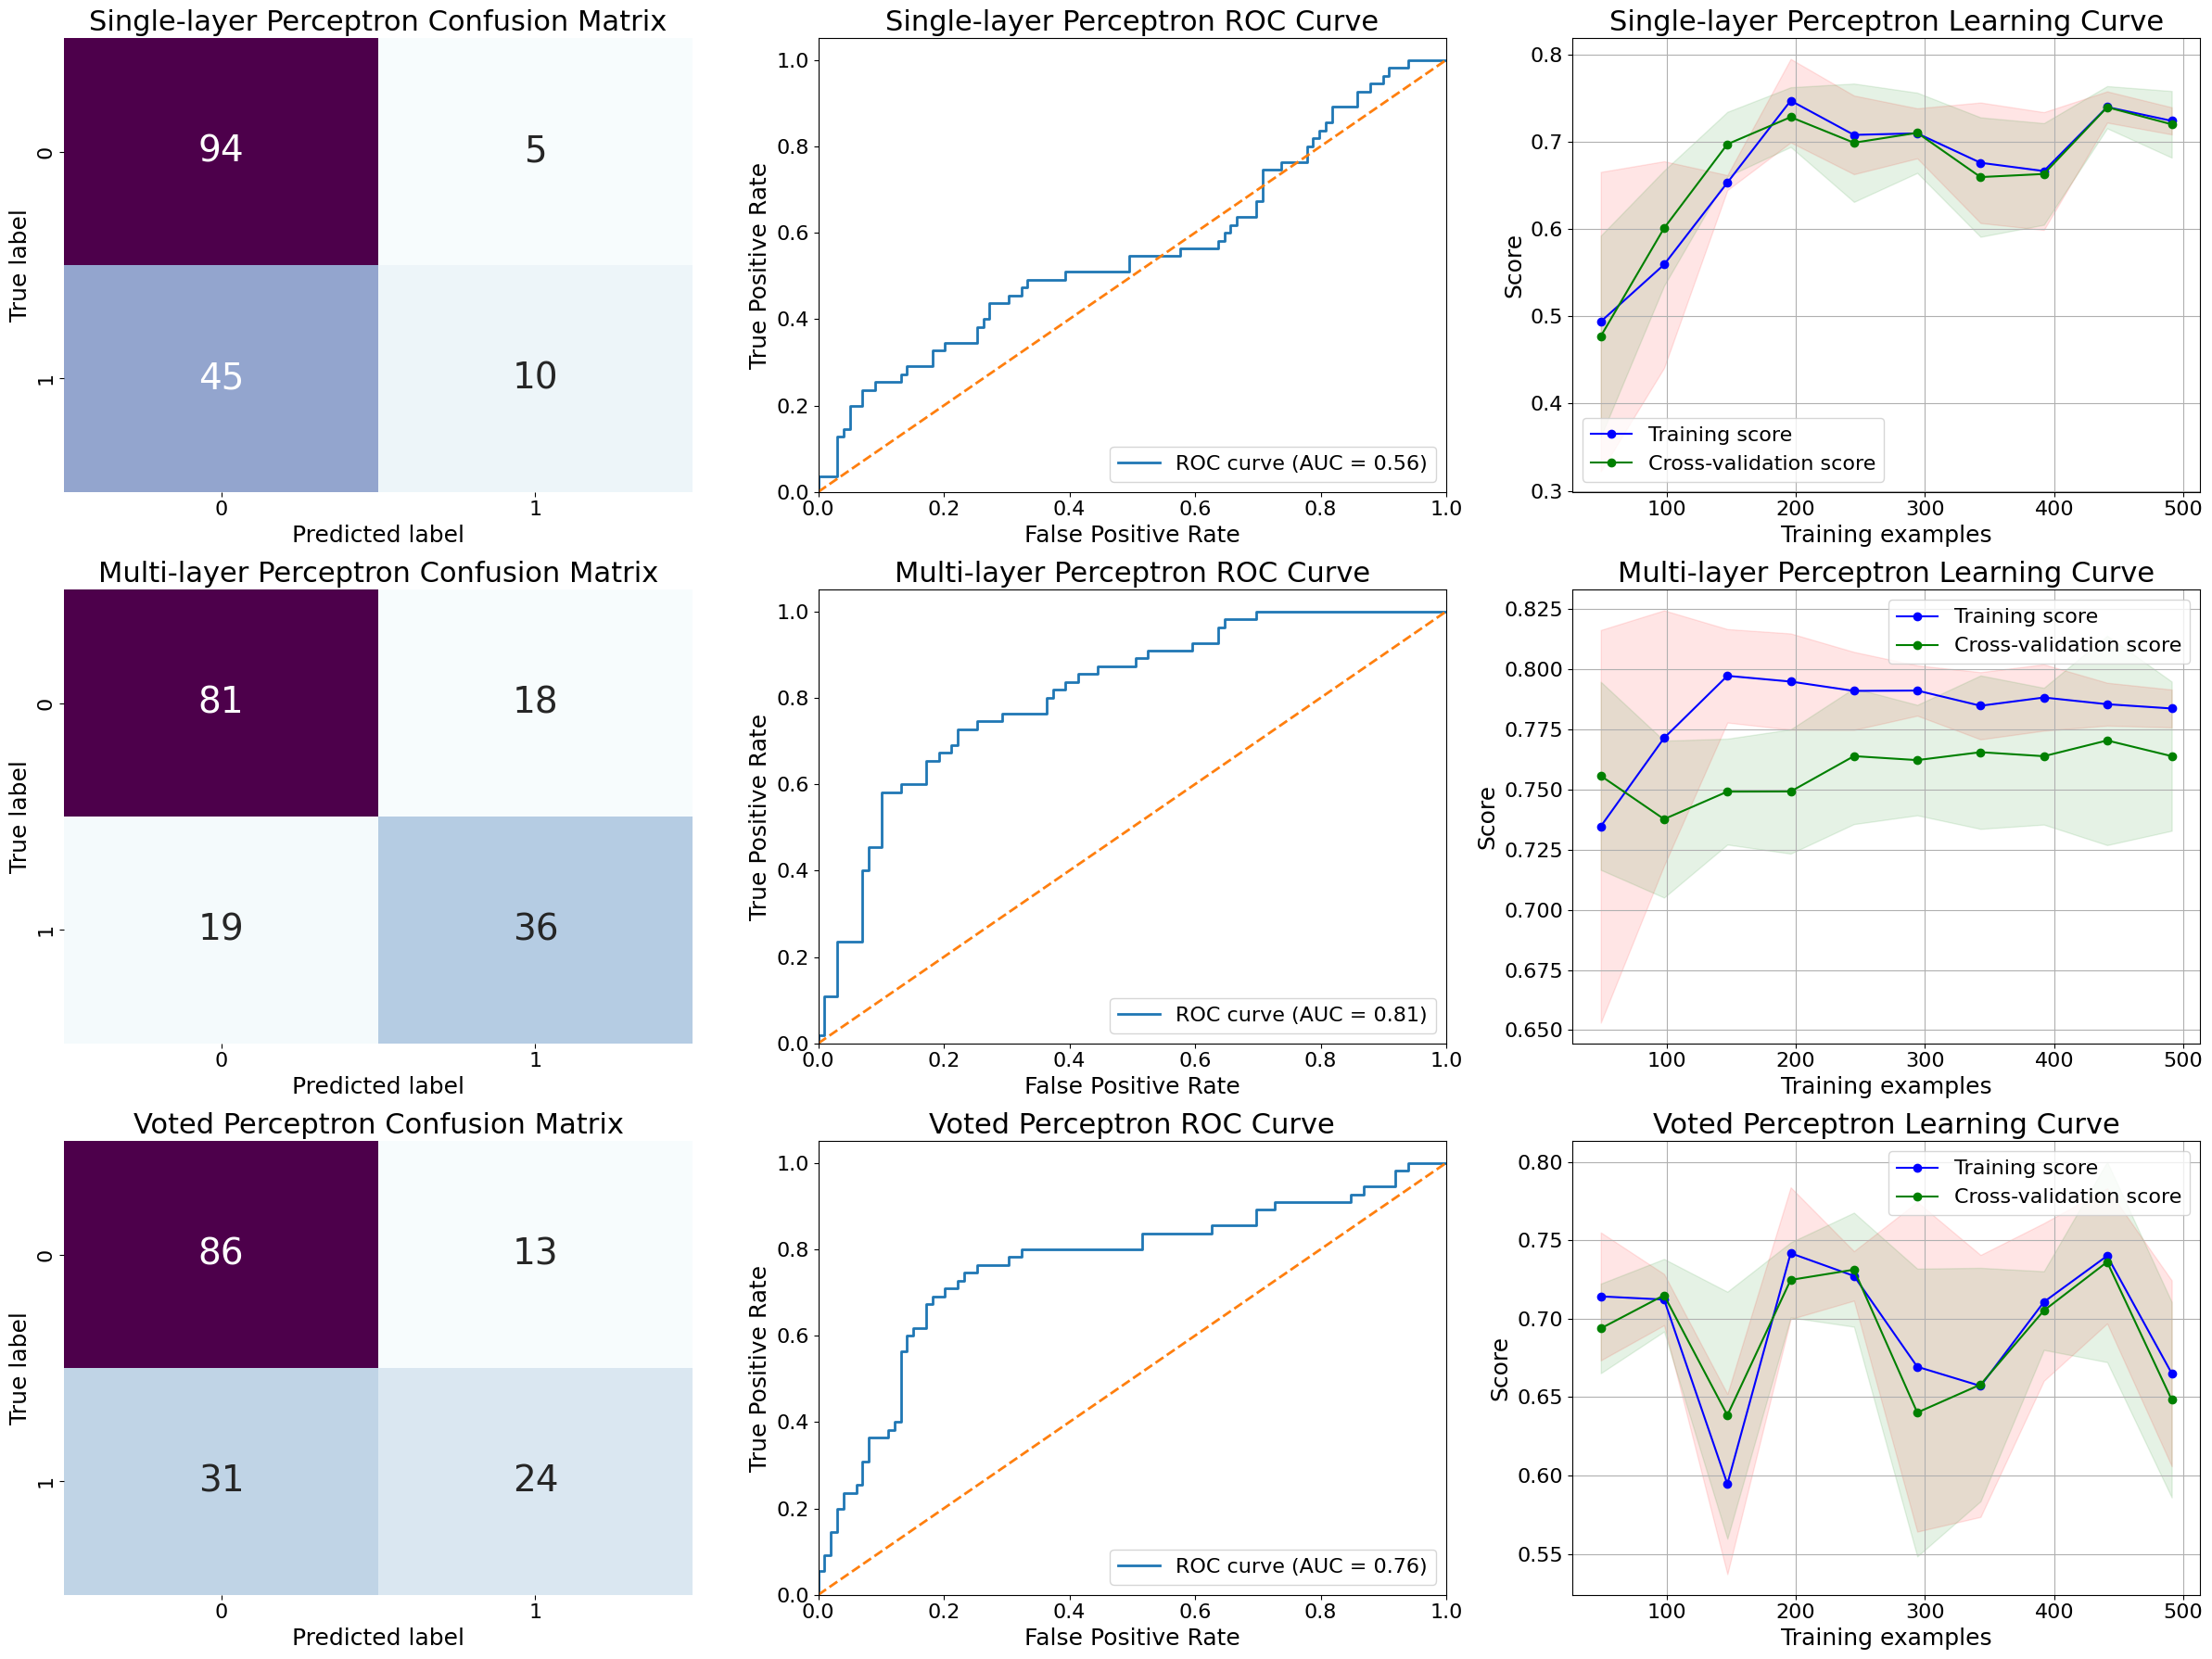

In [17]:
# Plotting curves side by side
fig, axs = plt.subplots(3, 3, figsize=(24, 18))

# SLP
plot_confusion_matrix(y_test, slp.predict(X_test_selected), axs[0, 0], "Single-layer Perceptron Confusion Matrix")
plot_roc_curve(y_test, slp.decision_function(X_test_selected), axs[0, 1], "Single-layer Perceptron ROC Curve")
plot_learning_curve(slp, X_train_selected, y_train, axs[0, 2], "Single-layer Perceptron Learning Curve")

# MLP
plot_confusion_matrix(y_test, mlp.predict(X_test_selected), axs[1, 0], "Multi-layer Perceptron Confusion Matrix")
plot_roc_curve(y_test, mlp.predict_proba(X_test_selected)[:, 1], axs[1, 1], "Multi-layer Perceptron ROC Curve")
plot_learning_curve(mlp, X_train_selected, y_train, axs[1, 2], "Multi-layer Perceptron Learning Curve")

# VP
plot_confusion_matrix(y_test, vp.predict(X_test_selected), axs[2, 0], "Voted Perceptron Confusion Matrix")
plot_roc_curve(y_test, vp.decision_function(X_test_selected), axs[2, 1], "Voted Perceptron ROC Curve")
plot_learning_curve(vp, X_train_selected, y_train, axs[2, 2], "Voted Perceptron Learning Curve")

plt.tight_layout()
plt.show()